In [32]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from piqa.ssim import SSIM
import numpy as np
import pandas as pd
from torchinfo import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [35]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms
)

In [36]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [37]:
# test if data can be inserted into dataloader
x, y = next(iter(train_dl))
x.shape

torch.Size([16, 1, 28, 28])

In [38]:
x[0, 0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [39]:
# hyperparameters
input_size = 28 * 28
hidden_sizes = [64, 32, 16]
latent_size = 8
output_size = input_size

In [40]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=input_size, hidden_sizes=hidden_sizes, latent_size=latent_size, output_size=output_size):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)

        return latent, reconstruction
    
model = AutoEncoder().to(device)
summary(model, (1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 8]                    --
├─Sequential: 1-1                        [1, 8]                    --
│    └─Linear: 2-1                       [1, 64]                   50,240
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 32]                   2,080
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 16]                   528
│    └─ReLU: 2-6                         [1, 16]                   --
│    └─Linear: 2-7                       [1, 8]                    136
├─Sequential: 1-2                        [1, 784]                  --
│    └─Linear: 2-8                       [1, 16]                   144
│    └─ReLU: 2-9                         [1, 16]                   --
│    └─Linear: 2-10                      [1, 32]                   544
│   

In [41]:
mse_loss = nn.MSELoss() # con: likes to make things blurry
ssim_loss = SSIM(n_channels=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [42]:
torch.manual_seed(42)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        X = X.reshape(-1, 28 * 28).to(device)

        # forward pass
        train_latent, train_reconstructions = model(X)

        # metrics
        loss = mse_loss(train_reconstructions, X) + 1 - ssim_loss(train_reconstructions.reshape(-1, 1, 28, 28), X.reshape(-1, 1, 28, 28))
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            X = X.reshape(-1, 28 * 28).to(device)


            # forward pass
            test_latent, test_reconstructions = model(X)

            # metrics
            test_loss += mse_loss(test_reconstructions, X) + 1 - ssim_loss(train_reconstructions.reshape(-1, 1, 28, 28), X.reshape(-1, 1, 28, 28))

        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.8459


 10%|█         | 1/10 [00:30<04:31, 30.12s/it]

Test Loss: 0.9429
Epoch: 1
------
Train Loss: 0.6390


 20%|██        | 2/10 [01:01<04:05, 30.73s/it]

Test Loss: 0.9240
Epoch: 2
------
Train Loss: 0.5997


 30%|███       | 3/10 [01:30<03:29, 29.98s/it]

Test Loss: 0.9226
Epoch: 3
------
Train Loss: 0.5807


 40%|████      | 4/10 [01:59<02:57, 29.61s/it]

Test Loss: 0.9218
Epoch: 4
------
Train Loss: 0.5616


 50%|█████     | 5/10 [02:27<02:24, 28.90s/it]

Test Loss: 0.9335
Epoch: 5
------
Train Loss: 0.5463


 60%|██████    | 6/10 [02:56<01:56, 29.09s/it]

Test Loss: 0.9297
Epoch: 6
------
Train Loss: 0.5317


 70%|███████   | 7/10 [03:27<01:29, 29.81s/it]

Test Loss: 0.9206
Epoch: 7
------
Train Loss: 0.5166


 80%|████████  | 8/10 [03:57<00:59, 29.73s/it]

Test Loss: 0.9299
Epoch: 8
------
Train Loss: 0.5030


 90%|█████████ | 9/10 [04:24<00:28, 28.91s/it]

Test Loss: 0.9281
Epoch: 9
------
Train Loss: 0.4913


100%|██████████| 10/10 [04:53<00:00, 29.36s/it]

Test Loss: 0.9266


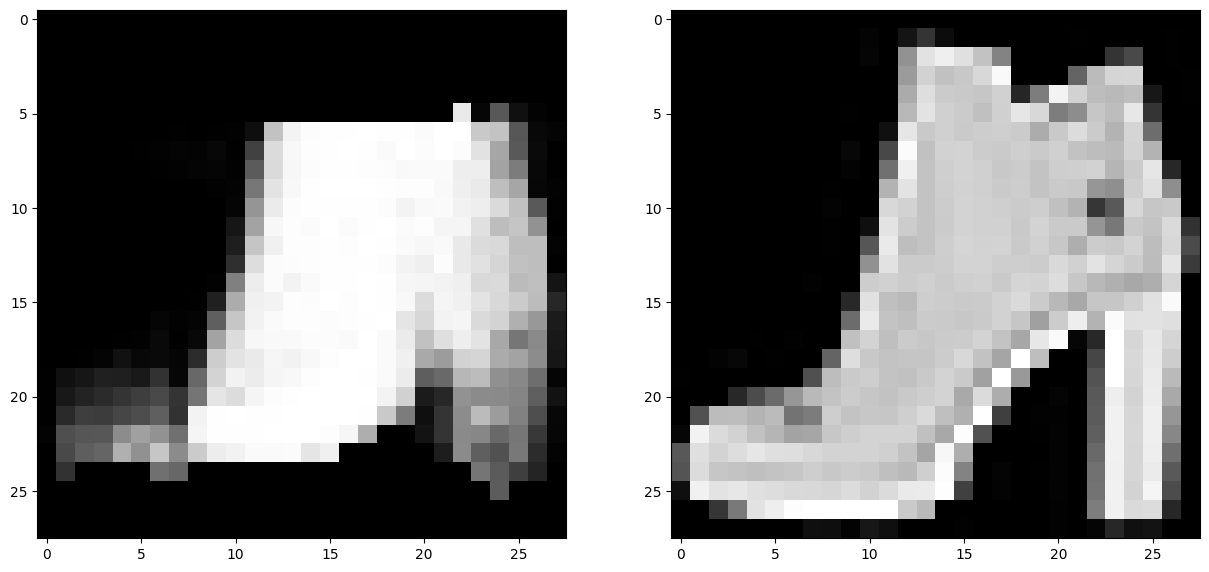

In [50]:
X, y = next(iter(train_dl))
X, y = X[0, :, :].reshape(1, 28*28).to(device), y[0].to(device)

sample_latent, sample_reconstruction = model(X)
sample_reconstruction = sample_reconstruction.reshape(28, 28).detach().cpu().numpy()

X_img = X.reshape(28, 28).detach().cpu().numpy()

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.imshow(sample_reconstruction, cmap="gray")

plt.subplot(122)
plt.imshow(X_img, cmap="gray")

In [44]:
# save_model(model, "ae.safetensors")